In [ ]:
import os
import re
import codecs
import pathlib
import glob
import datetime

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

n_jobs = -1

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla V100-SXM2-16GB, 418.67, 16130 MiB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df = pd.read_csv('/content/drive/My Drive/w2v_20_countries.txt',index_col=[0],sep='\t')

In [ ]:
directory = '/content/drive/My Drive/word2vec_sm_cleaned'

df_dict = {'country':[], 'text':[]}
for entry_country in os.scandir(directory):
  path = entry_country.path
  df = pd.read_csv(path, sep = '\t', index_col = 0)
  df_dict['country'] += list(df['country'])
  df_dict['text'] += list(df['text_cleaned'])

df_for_w2v = pd.DataFrame.from_dict(df_dict)

nine_countries_list = ['CA', 'NZ', 'SG','AU','GB','IE', 'PK', 'BD', 'NG','KE','ZA','TZ']

df_for_w2v = df_for_w2v[df_for_w2v['country'].isin(nine_countries_list)]
df = df_for_w2v.dropna()
df.reset_index(inplace=True)

df

,index,country,text
0,35686,ZA,malawian accuse terrorist kenya malawian natio...
1,35687,ZA,sos promote plead financial assistance newly p...
2,35688,ZA,man get year acid attack leave victim blind co...
3,35689,ZA,karonga flood claim live people die sweep way ...
4,35690,ZA,craftsman decry lack buyer craftsman express c...
...,...,...,...
933085,1381715,AU,image accuse man keiarhn carter lachlan mitche...
933086,1381716,AU,chiropractor jail kidnap plot build crematoriu...
933087,1381717,AU,headlines australian bank brawl apple revenue ...
933088,1381718,AU,collect encampment yesterday abandon bed compl...


In [ ]:
conditions = [
    (df['country'] == 'CA') | (df['country'] == 'NZ') | (df['country'] == 'SG') | (df['country'] == 'AU') | (df['country'] == 'GB') | (df['country'] == 'IE'),
    (df['country'] == 'PK') | (df['country'] == 'BD') | (df['country'] == 'NG') | (df['country'] == 'KE') | (df['country'] == 'ZA') | (df['country'] == 'TZ'),
    ]

# create a list of the values we want to assign for each condition
values = ['peaceful', 'non-peaceful',]

# create a new column and use np.select to assign values to it using our lists as arguments
df['peacefulness'] = np.select(conditions, values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df.head()

,index,country,text,peacefulness
0,35686,ZA,malawian accuse terrorist kenya malawian natio...,non-peaceful
1,35687,ZA,sos promote plead financial assistance newly p...,non-peaceful
2,35688,ZA,man get year acid attack leave victim blind co...,non-peaceful
3,35689,ZA,karonga flood claim live people die sweep way ...,non-peaceful
4,35690,ZA,craftsman decry lack buyer craftsman express c...,non-peaceful


In [ ]:
df.text[0]

'malawian accuse terrorist kenya malawian national face terrorism relate charge find sketch plan railway terminus kenyan port city mombasa man kristen prince kishombe august find sketch plan standard gauge railway terminus mombasa prosecutor believe draw order use act terrorism kristen prince kishombe accuse terrorist prosecutor kishombe refuse leave area prohibit passenger railway terminus appear court mombasa kishombe deny charge collect information claim football tell court pass country problem police implicate football player passenger take photo terminus sketch detail kishombe say'

In [ ]:
df = df[['text','peacefulness']]

In [ ]:
df.peacefulness.value_counts()

peaceful        596755
non-peaceful    336335
Name: peacefulness, dtype: int64

In [ ]:
df.dropna(inplace = True)
df.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.head()

,text,peacefulness
0,malawian accuse terrorist kenya malawian natio...,non-peaceful
1,sos promote plead financial assistance newly p...,non-peaceful
2,man get year acid attack leave victim blind co...,non-peaceful
3,karonga flood claim live people die sweep way ...,non-peaceful
4,craftsman decry lack buyer craftsman express c...,non-peaceful


In [ ]:
df.peacefulness.value_counts()

peaceful        596755
non-peaceful    336335
Name: peacefulness, dtype: int64

In [ ]:
def sampling_dataset(df):
    count = 50000
    class_df_sampled = pd.DataFrame(columns = ["peacefulness","text"])
    temp = []
    for c in df.peacefulness.unique():
        class_indexes = df[df.peacefulness == c].index
        random_indexes = np.random.choice(class_indexes, count, replace=False)
        temp.append(df.loc[random_indexes])
        
    for each_df in temp:
        class_df_sampled = pd.concat([class_df_sampled,each_df],axis=0)
    
    return class_df_sampled

df = sampling_dataset(df)
df.reset_index(drop=True,inplace=True)
print (df.head())
print (df.shape)

   peacefulness                                               text
0  non-peaceful  milestone achieve set world track future econo...
1  non-peaceful  lagos state commissioner police mr umaru manko...
2  non-peaceful  young mahin create history pakistan pakistan p...
3  non-peaceful  otieno otieno diminutive striker great night n...
4  non-peaceful  femi fani kayode way eagle lion king permit be...
(100000, 2)


In [ ]:
sum(df['text'].isna())

0

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [ ]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re

lmtzr = WordNetLemmatizer()
w = re.compile("\w+",re.I)

def label_sentences(df):
    labeled_sentences = []
    for index, datapoint in df.iterrows():
        tokenized_words = re.findall(w,datapoint["text"].lower())
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))
    return labeled_sentences

def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(alpha=0.025, min_alpha=0.025)
    model.build_vocab(labeled_sentences)
    for epoch in range(10):
        model.train(tqdm(labeled_sentences),total_examples=model.corpus_count,epochs=model.epochs)
        model.alpha -= 0.002 
        model.min_alpha = model.alpha
    
    return model

sen = label_sentences(df)
model = train_doc2vec_model(sen)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  from ipykernel import kernelapp as app
100%|██████████| 100000/100000 [00:38<00:00, 2620.04it/s]


In [ ]:
def vectorize_comments(df,d2v_model):
    y = []
    comments = []
    for i in range(0,df.shape[0]):
        label = 'SENT_%s' %i
        comments.append(d2v_model.docvecs[label])
    df['vectorized_comments'] = comments
    
    return df

df = vectorize_comments(df,model)
print (df.head(2))

   peacefulness  ...                                vectorized_comments
0  non-peaceful  ...  [-1.9986039, 0.9381497, 1.1435105, -0.06345977...
1  non-peaceful  ...  [-4.4682717, -0.8725656, -1.9141116, 0.5902374...

[2 rows x 3 columns]


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle

def train_classifier(X,y):
    n_estimators = [200,400]
    min_samples_split = [2]
    min_samples_leaf = [1]
    bootstrap = [True]

    parameters = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf,
                  'min_samples_split': min_samples_split}

    clf = GridSearchCV(RFC(verbose=1,n_jobs=4), cv=4, param_grid=parameters)
    clf.fit(X, y)
    return clf

X_train, X_test, y_train, y_test = train_test_split(df["vectorized_comments"].T.tolist(), df["peacefulness"], test_size=0.02, random_state=17)
classifier = train_classifier(X_train,y_train)
print (classifier.best_score_, "----------------Best Accuracy score on Cross Validation Sets")
print (classifier.score(X_test,y_test))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

0.7614795918367346 ----------------Best Accuracy score on Cross Validation Sets
0.7555


[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished


In [ ]:
from sklearn.metrics import classification_report
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished


              precision    recall  f1-score   support

non-peaceful       0.78      0.72      0.75      1021
    peaceful       0.73      0.79      0.76       979

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



In [ ]:
from sklearn.metrics import confusion_matrix
labeels = ['non-peaceful','peaceful']
cm = confusion_matrix(y_test, y_pred,labels=labeels)

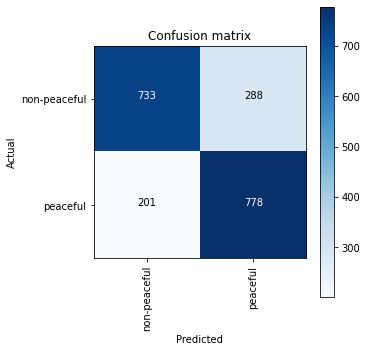

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,normalize=False):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

dict_characters = {0: 'non-peaceful', 1: 'peaceful'}

# y_pred = model.predict(test_data)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(test_labels, axis=1)

confusion_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mat, classes = list(dict_characters.values()))